# Test Panels

In [1]:
import ipywidgets as ipw
import datetime
from IPython.display import display
import numpy as np
import pandas as pd
from collections import OrderedDict
import json
import aurora.schemas.data_schemas
from aurora.schemas.data_schemas import BatterySpecs, BatteryComposition, BatteryCapacity, BatteryMetadata, BatterySample, BatterySpecsJsonTypes, BatterySampleJsonTypes
import aurora.schemas.cycling
from aurora.schemas.cycling import ElectroChemPayloads, CyclingParameter, CyclingTechnique, ElectroChemSequence
from aurora.schemas.convert import pd_dataframe_to_formatted_json, dict_to_formatted_json, remove_empties_from_dict_decorator, _remove_empties_from_dict
import pydantic, typing
import logging

# import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
ElectroChemPayloads.__args__

(aurora.schemas.cycling.DummyRandom,
 aurora.schemas.cycling.OpenCircuitVoltage,
 aurora.schemas.cycling.ConstantCurrent,
 aurora.schemas.cycling.ConstantVoltage,
 aurora.schemas.cycling.Loop)

## 0. Load mock data

- TODO: convert all capacities to mAh to make queries simpler?

- We impose the properties data types from this dictionary. They should actually be obtained from the BatterySample pydantic schema... **how do we do that?**

In [3]:
def load_available_specs():
    STD_SPECS = pd.read_csv('sample_specs.csv', dtype=BatterySpecsJsonTypes)
    return STD_SPECS

def load_available_samples():
    # AVAIL_SAMPLES = [BatterySample.parse_obj(dic) for dic in json.load(open('available_samples.json', 'r'))]
    # AVAIL_SAMPLES_D = {battery_id: BatterySample.parse_obj(dic) for battery_id, dic in json.load(open('available_samples_id.json', 'r')).items()}
    with open('available_samples.json', 'r') as f:
        data = json.load(f)
    # load json and enforce data types
    AVAIL_SAMPLES_DF = pd.json_normalize(data)
    AVAIL_SAMPLES_DF = AVAIL_SAMPLES_DF.astype(dtype={col: typ for col, typ in BatterySampleJsonTypes.items() if col in AVAIL_SAMPLES_DF.columns})
    AVAIL_SAMPLES_DF["metadata.creation_datetime"] = pd.to_datetime(AVAIL_SAMPLES_DF["metadata.creation_datetime"])
    return AVAIL_SAMPLES_DF

STD_RECIPIES = {
    'Load fresh battery into cycler': ['Request the user to load a battery with the desired specs.'],
    'Synthesize - Recipe 1': ['step 1', 'step 2', 'step 3'],
    'Synthesize - Recipe 2': ['step 1', 'step 2', 'step 3'],
}

def load_available_recipies():
    global STD_RECIPIES
    return STD_RECIPIES.copy()

In [4]:
available_samples = load_available_samples()
available_specs = load_available_specs()
available_recipies = load_available_recipies()

def update_available_samples():
    global available_samples
    available_samples = load_available_samples()

def update_available_specs():
    global available_specs
    available_specs = load_available_specs()

def update_available_recipies():
    global available_recipies
    available_recipies = load_available_recipies()

In [5]:
available_samples

,manufacturer,form_factor,battery_id,composition.description,capacity.nominal,capacity.actual,capacity.units,metadata.name,metadata.creation_datetime,metadata.creation_process
0,BIG-MAP,2032,3,Si-C | LNMO | NMC622,1.539,NaN,mAh,3_BIGMAP_20220309,2022-03-09 07:10:22+00:00,"Lorem ipsum dolor sit amet, consectetur adipis..."
1,Conrad energy,2032,33,Li-based,60.000,NaN,mAh,33_Conradenergy_20201211,2020-12-11 02:29:10+00:00,"Lorem ipsum dolor sit amet, consectetur adipis..."
2,Conrad energy,2032,44,Li-based,45.000,NaN,mAh,44_Conradenergy_20220207,2022-02-07 21:34:16+00:00,"Lorem ipsum dolor sit amet, consectetur adipis..."
3,Conrad energy,2032,56,Li-based,45.000,NaN,mAh,56_Conradenergy_20210418,2021-04-18 14:53:51+00:00,"Lorem ipsum dolor sit amet, consectetur adipis..."
4,BIG-MAP,2032,121,C | LP57 | LNO,4.618,NaN,mAh,121_BIGMAP_20220307,2022-03-07 01:19:31+00:00,"Lorem ipsum dolor sit amet, consectetur adipis..."
5,Conrad energy,2032,128,Li-based,60.000,NaN,mAh,128_Conradenergy_20210905,2021-09-05 04:47:34+00:00,"Lorem ipsum dolor sit amet, consectetur adipis..."
6,Conrad energy,2032,137,Li-based,60.000,NaN,mAh,137_Conradenergy_20210716,2021-07-16 00:02:37+00:00,"Lorem ipsum dolor sit amet, consectetur adipis..."
7,BIG-MAP,2032,171,Si-C | LNMO | NMC622,1.539,NaN,mAh,171_BIGMAP_20210704,2021-07-04 00:54:09+00:00,"Lorem ipsum dolor sit amet, consectetur adipis..."
8,BIG-MAP,2032,306,Si-C | LP57 | NMC811,4.618,NaN,mAh,306_BIGMAP_20210716,2021-07-16 18:13:33+00:00,"Lorem ipsum dolor sit amet, consectetur adipis..."
9,BIG-MAP,2032,313,Si-C | LNMO | NMC622,4.618,NaN,mAh,313_BIGMAP_20220428,2022-04-28 01:01:03+00:00,"Lorem ipsum dolor sit amet, consectetur adipis..."


In [10]:
def query_available_specs(field: str = None):
    """
    This mock function returns a pandas.DataFrame of allowed specs.
        field (optional): name of a field to query [manufacturer, composition, capacity, form_factor]
    """
    global available_specs
    
    if field:
        return available_specs.get(field).unique().tolist()
    else:
        return available_specs

def query_available_samples(query=None, project=None):
    """
    This mock function returns the available samples.
        query: a pandas query
        project (optional): list of the columns to return (if None, return all)
    
    Returns a pandas.DataFrame or Series
    """
    global available_samples
    
    # perform query
    if query is not None:
        results = available_samples.query(query)
    else:
        results = available_samples
    if project and (results is not None):
        if not isinstance(project, list):
            project = [project]
        return results[project]
    else:
        return results

def query_available_recipies():
    """A mock function that returns the available synthesis recipies."""
    global available_recipies
    return available_recipies

def write_pd_query_from_dict(query_dict):
    """
    Write a pandas query from a dictionary {field: value}.
    Example: 
        write_pandas_query({'manufacturer': 'BIG-MAP', 'battery_id': 98})
    returns "(`manufacturer` == 'BIG-MAP') and (`battery_id` == 98)"
    """
    query = " and ".join(["(`{}` == {})".format(k, f"{v}" if isinstance(v, (int, float)) else f"'{v}'") for k, v in query_dict.items() if v])
    if query:
        return query

## 1. Sample selection

In [22]:
def test_validate_sample_callback_function(obj):
    """Function that validates inputs and returns the needed info."""
    print(obj.selected_sample_dict)
    return obj.selected_sample_dict

def test_validate_specs_recipe_callback_function(obj):
    """Function that validates inputs and returns the needed info."""
    print(obj.selected_specs_dict)
    print(obj.selected_recipe_dict)
    return {'specs': obj.selected_specs_dict, 'recipe': obj.selected_recipe_dict}

def test_generic_callback_function(obj):
    print("I'm calling the callback function.")
    return obj

### **From Battery ID**

In [327]:
class SampleFromId(ipw.VBox):
    
    BOX_LAYOUT_1 = {'width': '50%'}
    BOX_STYLE = {'description_width': '15%'}
    BUTTON_STYLE = {'description_width': '30%'}
    BUTTON_LAYOUT = {'margin': '5px'}
    MAIN_LAYOUT = {'width': '100%', 'padding': '10px', 'border': 'solid blue 2px'}

    def __init__(self, validate_callback_f):
        
        # initialize widgets
        self.w_header_label = ipw.HTML(value="<h2>Battery Selection</h2>")
        self.w_id_list = ipw.Select(
            rows=10,
            description="Battery ID:",
            style=self.BOX_STYLE, layout=self.BOX_LAYOUT_1)
        self.w_update = ipw.Button(
            description="Update",
            button_style='', tooltip="Update available samples", icon='refresh',
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT)
        self.w_sample_preview = ipw.Output()
        self.w_validate = ipw.Button(
            description="Validate",
            button_style='success', tooltip="Validate the selected sample", icon='check',
            disabled=True,
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT)
        
        super().__init__()
        self.children = [
            self.w_header_label,
            ipw.VBox([
                ipw.HBox([self.w_id_list,
                self.w_update,]),
                self.w_sample_preview,
                self.w_validate,
            ], layout=self.MAIN_LAYOUT),
        ]
        
        # initialize options
        if not callable(validate_callback_f):
            raise TypeError("validate_callback_f should be a callable function")
        # self.validate_callback_f = validate_callback_f
        self.w_id_list.value = None
        self.on_update_button_clicked()
        
        # setup automations
        self.w_update.on_click(self.on_update_button_clicked)
        self.w_id_list.observe(handler=self.on_battery_id_change, names='value')
        self.w_validate.on_click(lambda arg: self.on_validate_button_clicked(validate_callback_f))


    @property
    def selected_sample_id(self):
        return self.w_id_list.value
    
    @property
    def selected_sample_dict(self):
        return dict_to_formatted_json(
            query_available_samples(write_pd_query_from_dict({'battery_id': self.w_id_list.value})).iloc[0])

    @staticmethod
    def _build_sample_id_options():
        """Returns a (option_string, battery_id) list."""
        # table = query_available_samples(project=['battery_id', 'metadata.name']).sort_values('battery_id')
        table = query_available_samples().sort_values('battery_id')
        def row_label(row):
            # return f"<{row['battery_id']:8}>   \"{row['metadata.name']}\""
            return f"{row['battery_id']:8}   [{row['manufacturer'].split()[0]}]  ({row['capacity.nominal']} {row['capacity.units']})  {row['composition.description']}"
        return [("", None)] + [(row_label(row), row['battery_id']) for index, row in table.iterrows()]

    def display_sample_preview(self):
        self.w_sample_preview.clear_output()
        if self.w_id_list.value is not None:
            with self.w_sample_preview:
                display(query_available_samples(write_pd_query_from_dict({'battery_id': self.w_id_list.value})))

    def update_validate_button_state(self):
        self.w_validate.disabled = (self.w_id_list.value is None)

    def on_battery_id_change(self, _ = None):
        self.display_sample_preview()
        self.update_validate_button_state()

    def on_update_button_clicked(self, _ = None):
        update_available_samples()
        self.w_id_list.options = self._build_sample_id_options()

    def on_validate_button_clicked(self, callback_function):
        # call the validation callback function
        return callback_function(self)

In [328]:
w_sample_from_id = SampleFromId(test_validate_sample_callback_function)
w_sample_from_id

SampleFromId(children=(HTML(value='<h2>Battery Selection</h2>'), VBox(children=(HBox(children=(Select(descript…

### **From Battery Specs** (loaded from available ones)

Function to perform query of samples. Options are taken from available specs (assuming they are representative of the samples' specs).\
Next to each option is the number of samples available. Once I selected the specs, a list of matching samples is generated.

When the user selects a spec value, the options of all the fields must be updated.\
*Be aware that changing the options does not preserve the value, so we must enforce it!*

Each `spec_field` contains the number of structures obtained by filtering the samples *without* the field's current value.

In [7]:
# @ipw.widget.register
# class ComboboxWithOptions(ipw.Combobox):
#     """
#     Single line textbox widget with a dropdown and autocompletion.
#     Supports (label, value) pairs options, like ipw.Select.
#     """
#     def set_options(self, x):
#         print(f'setting options -- value = {self.value}')
#         self._options_full = ipw.widget_selection._make_options(x)
#         self._options_labels = [pair[0] for pair in self._options_full]
#         self._options_values = [pair[1] for pair in self._options_full]
#         self._options_dict = {pair[0]: pair[1] for pair in self._options_full}
#         self.options = self._options_labels
    
#     @property
#     def current_value(self):
#         """The actual value of the chosen option."""
#         return self._options_dict[self.value]
    
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#         self.set_options(self.options)

In [350]:
class SampleFromSpecs(ipw.VBox):

    _DEBUG = False
    QUERIABLE_SPECS = {
        "manufacturer": "Manufacturer",
        "composition.description": "Composition",
        "capacity.nominal": "Nominal capacity",
        "form_factor": "Form factor",
        # "metadata.creation_datetime": "Creation date",
    }
    BOX_LAYOUT_1 = {'width': '40%'}
    BOX_LAYOUT_2 = {'width': '100%', 'height': '100px'}
    BOX_STYLE = {'description_width': '25%'}
    BUTTON_STYLE = {'description_width': '30%'}
    BUTTON_LAYOUT = {'margin': '5px'}
    OUTPUT_LAYOUT = {'max_height': '500px', 'width': '90%', 'overflow': 'scroll', 'border': 'solid 2px', 'margin': '5px', 'padding': '5px'}
    SAMPLE_BOX_LAYOUT = {'width': '90%', 'border': 'solid blue 2px', 'align_content': 'center', 'margin': '5px', 'padding': '5px'}
    QUERY_PRINT_COLUMNS = ['manufacturer', 'composition.description', 'capacity.nominal', 'capacity.actual', 'capacity.units', 'form_factor',# 'metadata.name',
                       'metadata.creation_datetime'] #, 'metadata.creation_process']
    
    def __init__(self, validate_callback_f, recipe_callback_f):

        if not callable(validate_callback_f):
            raise TypeError("validate_callback_f should be a callable function")
        if not callable(recipe_callback_f):
            raise TypeError("recipe_callback_f should be a callable function")

        # initialize widgets
        self.w_specs_header = ipw.HTML(value="<h2>Battery Specifications</h2>")
        self.w_specs_manufacturer = ipw.Select(
            description="Manufacturer:",
            placeholder="Enter manufacturer",
            layout=self.BOX_LAYOUT_2, style=self.BOX_STYLE)
        self.w_specs_composition = ipw.Select(
            description="Composition:",
            placeholder="Enter composition",
            layout=self.BOX_LAYOUT_2, style=self.BOX_STYLE)
        self.w_specs_capacity = ipw.Select(
            description="Nominal capacity:",
            placeholder="Enter nominal capacity",
            layout=self.BOX_LAYOUT_2, style=self.BOX_STYLE)
        self.w_specs_form_factor = ipw.Select(
            description="Form factor:",
            placeholder="Enter form factor",
            layout=self.BOX_LAYOUT_2, style=self.BOX_STYLE)
        # self.w_specs_metadata_creation_date = ipydatetime.DatetimePicker(
        #     description="Creation time:",
        #     style=BOX_STYLE)
        # self.w_specs_metadata_creation_process = ipw.Text(
        #     description="Creation process",
        #     placeholder="Describe creation process",
        #     style=BOX_STYLE)

        self.w_update = ipw.Button(
            description="Update",
            button_style='', tooltip="Update available samples", icon='refresh',
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT)
        self.w_reset = ipw.Button(
            description="Reset",
            button_style='danger', tooltip="Clear fields", icon='times',
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT)
        self.w_query_result = ipw.Output(layout=self.OUTPUT_LAYOUT)

        self.w_select_sample_id = ipw.Dropdown(
            description="Select Battery ID:", value=None,
            layout=self.BOX_LAYOUT_1, style={'description_width': 'initial'})
        self.w_cookit = ipw.Button(
            description="Load/Synthesize new", #['primary', 'success', 'info', 'warning', 'danger', '']
            button_style='primary', tooltip="Synthesize sample with these specs", icon='',
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT)
        self.w_sample_preview = ipw.Output()
        self.w_validate = ipw.Button(
            description="Validate",
            button_style='success', tooltip="Validate the selected sample", icon='check',
            disabled=True,
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT)

        super().__init__()
        self.children = [
            self.w_specs_header,
            ipw.GridBox([
                self.w_specs_manufacturer,
                self.w_specs_composition,
                self.w_specs_capacity,
                self.w_specs_form_factor,
                # self.w_specs_metadata_creation_date,
                # self.w_specs_metadata_creation_process,
            ], layout=ipw.Layout(grid_template_columns="repeat(2, 45%)")),
            ipw.HBox([self.w_update, self.w_reset], layout={'justify_content': 'center', 'margin': '5px'}),
            self.w_query_result,
            ipw.VBox([
                ipw.HBox([self.w_select_sample_id, ipw.Label(' or '), self.w_cookit], layout={'justify_content': 'space-around'}),
                self.w_sample_preview,
            ], layout=self.SAMPLE_BOX_LAYOUT),
            self.w_validate
        ]

        # initialize options
        self.on_reset_button_clicked()
        update_available_specs()
        self._update_options()
        self.display_query_result()

        # setup automations
        self.w_update.on_click(self.on_update_button_clicked)
        self.w_reset.on_click(self.on_reset_button_clicked)
        self._set_specs_observers()
        self.w_select_sample_id.observe(handler=self.on_battery_id_change, names='value')
        self.w_validate.on_click(lambda arg: self.callback_call(validate_callback_f))
        self.w_cookit.on_click(lambda arg: self.callback_call(recipe_callback_f))


    @property
    def selected_sample_id(self):
        return self.w_select_sample_id.value

    @property
    def selected_sample_dict(self):
        return dict_to_formatted_json(
            query_available_samples(write_pd_query_from_dict({'battery_id': self.w_select_sample_id.value})).iloc[0])

    @property
    def current_specs(self):
        """
        A dictionary representing the current specs set by the user, that can be used in a query
        to filter the available samples.
        """
        return {
            'manufacturer': self.w_specs_manufacturer.value,
            'composition.description': self.w_specs_composition.value,
            'capacity.nominal': self.w_specs_capacity.value,
            'form_factor': self.w_specs_form_factor.value,
            # 'metadata.creation_datetime': self.w_specs_metadata_creation_date.value
        }

    def _build_sample_specs_options(self, spec_field):
        """
        Returns a `(option_string, battery_id)` list.
        The specs currently set are used to filter the sample list.
        The current `spec_field` is removed from the query, as we want to count how many samples correspond to each
        available value of the `spec_field`.
        """
        spec_field_options_list = query_available_specs(spec_field)

        # setup sample query filter from current specs and remove current field from query
        sample_query_filter_dict = self.current_specs.copy()
        sample_query_filter_dict[spec_field] = None

        # perform query of samples
        if self._DEBUG:
            print("\nSPEC FIELD: ", spec_field)
            print(f"       {spec_field_options_list}")
            print(" QUERY: ", sample_query_filter_dict)

        qres = query_available_samples(write_pd_query_from_dict(sample_query_filter_dict),
                                       project=[spec_field, 'battery_id']).sort_values('battery_id')

        # count values
        value_counts = qres[spec_field].value_counts()
        if self._DEBUG:
            print(' counts:', value_counts.to_dict())
        options_pairs = [(f"(no filter)  [{value_counts.sum()}]", None)]
        options_pairs.extend([(f"{value}  [{value_counts.get(value, 0)}]", value) for value in spec_field_options_list])
        return options_pairs

    def _build_sample_id_options(self):
        """Returns a (option_string, battery_id) list."""
        table = query_available_samples(write_pd_query_from_dict(self.current_specs)).sort_values('battery_id')
        return [("", None)] + [(f"<{row['battery_id']:5}>   \"{row['metadata.name']}\"", row['battery_id']) for index, row in table.iterrows()]
    
    def _update_options(self):
        # first save current values to preserve them
        w_specs_manufacturer_value = self.w_specs_manufacturer.value
        w_specs_composition_value = self.w_specs_composition.value
        w_specs_capacity_value = self.w_specs_capacity.value
        w_specs_form_factor_value = self.w_specs_form_factor.value
        self.w_specs_manufacturer.options = self._build_sample_specs_options('manufacturer')
        self.w_specs_manufacturer.value = w_specs_manufacturer_value
        self.w_specs_composition.options = self._build_sample_specs_options('composition.description')
        self.w_specs_composition.value = w_specs_composition_value
        self.w_specs_capacity.options = self._build_sample_specs_options('capacity.nominal')
        self.w_specs_capacity.value = w_specs_capacity_value
        self.w_specs_form_factor.options = self._build_sample_specs_options('form_factor')
        self.w_specs_form_factor.value = w_specs_form_factor_value
        self.w_select_sample_id.options = self._build_sample_id_options()
        self.w_select_sample_id.value = None

    def update_options(self):
        """Update the specs' options."""
        if self._DEBUG:
            print(f'updating options!')
        self._unset_specs_observers()
        self._update_options()
        self._set_specs_observers()

    def display_query_result(self):
        self.w_query_result.clear_output()
        with self.w_query_result:
            # print(f'Query:\n  {self.current_specs}')
            query_res = query_available_samples(write_pd_query_from_dict(self.current_specs)).set_index('battery_id')[self.QUERY_PRINT_COLUMNS]
            # query_res['metadata.creation_datetime'] = query_res['metadata.creation_datetime'].dt.strftime("%d-%m-%Y %H:%m")
            # display(query_res.style.format(formatter={'metadata.creation_datetime': lambda t: t.strftime("%d-%m-%Y")}))
            display(query_res)

    def display_sample_preview(self):
        self.w_sample_preview.clear_output()
        if self.w_select_sample_id.value is not None:
            with self.w_sample_preview:
                # display(query_available_samples(write_pd_query_from_dict({'battery_id': self.w_select_sample_id.value})))
                print(query_available_samples(write_pd_query_from_dict({'battery_id': self.w_select_sample_id.value})).iloc[0])

    def update_validate_button_state(self):
        self.w_validate.disabled = (self.w_select_sample_id.value is None)

    # def on_specs_value_change(self, which):
    #     def update_fields(_):
    #         self.display_query_result()
    #         self.update_options()#which)
    #     return update_fields

    def on_specs_value_change(self, _=None):
        self.update_options()
        self.display_query_result()

    def on_update_button_clicked(self, _=None):
        update_available_specs()
        update_available_samples()
        self.update_options()
        self.display_query_result()
        # notice: if the old value is not available anymore, an error might be raised!

    def on_reset_button_clicked(self, _=None):
        self.w_specs_manufacturer.value = None
        self.w_specs_composition.value = None
        self.w_specs_form_factor.value = None
        self.w_specs_capacity.value = None
        # self.w_specs_metadata_creation_date.value = None
        # self.w_specs_metadata_creation_process.value = None

    def on_battery_id_change(self, _=None):
        self.display_sample_preview()
        self.update_validate_button_state()

    def callback_call(self, callback_function):
        # call a callback function and pass it this class instance
        return callback_function(self)

    def _set_specs_observers(self):
        self.w_specs_manufacturer.observe(handler=self.on_specs_value_change, names='value')
        self.w_specs_composition.observe(handler=self.on_specs_value_change, names='value')
        self.w_specs_capacity.observe(handler=self.on_specs_value_change, names='value')
        self.w_specs_form_factor.observe(handler=self.on_specs_value_change, names='value')
        # self.w_specs_metadata_creation_date.observe(handler=self.update_options, names='value')
    
    def _unset_specs_observers(self):
        self.w_specs_manufacturer.unobserve(handler=self.on_specs_value_change, names='value')
        self.w_specs_composition.unobserve(handler=self.on_specs_value_change, names='value')
        self.w_specs_capacity.unobserve(handler=self.on_specs_value_change, names='value')
        self.w_specs_form_factor.unobserve(handler=self.on_specs_value_change, names='value')
        # self.w_specs_metadata_creation_date.unobserve(handler=self.update_options, names='value')

In [351]:
w_sample_from_specs = SampleFromSpecs(test_validate_sample_callback_function, test_generic_callback_function)
w_sample_from_specs

SampleFromSpecs(children=(HTML(value='<h2>Battery Specifications</h2>'), GridBox(children=(Select(description=…

In [336]:
q = query_available_samples(write_pd_query_from_dict(w_sample_from_specs.current_specs)).set_index('battery_id')

def make_pretty(styler):
    styler.format(formatter={'metadata.creation_datetime': lambda t: t.strftime("%d-%m-%Y")})
    styler.set_table_styles([
        {'selector': 'td:hover', 'props': 'background-color: #ffffc3;'},
        {'selector': '.index_name', 'props': 'font-style: italic; color: black; font-weight:normal;'},
        # {'selector': 'td.row_heading', 'props': 'height: 10px'},
        # {'selector': 'td', 'props': 'row_trim: 5'}
        {"selector": "tr", "props": "line-height: 10px;"},
        {"selector": "td,th", "props": "line-height: inherit; padding: 5px;"}
    ])
    return styler

q.style.pipe(make_pretty)

,manufacturer,form_factor,composition.description,capacity.nominal,capacity.actual,capacity.units,metadata.name,metadata.creation_datetime,metadata.creation_process
battery_id,,,,,,,,,
20,Conrad energy,2032,Li-based,45.000000,nan,mAh,Otis_20,08-10-2020,"Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed mollis arcu ac risus vestibulum, ac commodo nunc euismod. Vivamus suscipit eros nec justo faucibus, et eleifend diam eleifend."
30,BIG-MAP,2032,Si-C | LNMO | NMC622,1.539000,nan,mAh,Michael_30,23-01-2022,"Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed mollis arcu ac risus vestibulum, ac commodo nunc euismod. Vivamus suscipit eros nec justo faucibus, et eleifend diam eleifend."
41,BIG-MAP,2032,Si-C | LNMO | NMC622,4.618000,nan,mAh,Danielle_41,03-02-2022,"Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed mollis arcu ac risus vestibulum, ac commodo nunc euismod. Vivamus suscipit eros nec justo faucibus, et eleifend diam eleifend."
55,Conrad energy,2032,Li-based,45.000000,nan,mAh,Michael_55,02-07-2021,"Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed mollis arcu ac risus vestibulum, ac commodo nunc euismod. Vivamus suscipit eros nec justo faucibus, et eleifend diam eleifend."
71,BIG-MAP,2032,Si-C | LP57 | NMC811,1.539000,nan,mAh,Deborah_71,31-12-2021,"Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed mollis arcu ac risus vestibulum, ac commodo nunc euismod. Vivamus suscipit eros nec justo faucibus, et eleifend diam eleifend."
73,Maxell,2016,LiMgO2-based,60.000000,nan,mAh,James_73,05-01-2021,"Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed mollis arcu ac risus vestibulum, ac commodo nunc euismod. Vivamus suscipit eros nec justo faucibus, et eleifend diam eleifend."
76,BIG-MAP,2032,Si-C | LNMO | NMC622,1.539000,nan,mAh,Doris_76,08-12-2020,"Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed mollis arcu ac risus vestibulum, ac commodo nunc euismod. Vivamus suscipit eros nec justo faucibus, et eleifend diam eleifend."
132,BIG-MAP,2032,Si-C | LP57 | NMC811,1.539000,nan,mAh,Roger_132,27-01-2020,"Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed mollis arcu ac risus vestibulum, ac commodo nunc euismod. Vivamus suscipit eros nec justo faucibus, et eleifend diam eleifend."
184,BIG-MAP,2032,C | LP57 | NMC811,4.618000,nan,mAh,Scott_184,07-12-2020,"Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed mollis arcu ac risus vestibulum, ac commodo nunc euismod. Vivamus suscipit eros nec justo faucibus, et eleifend diam eleifend."


In [290]:
with pd.option_context("display.max_rows", 1, "display.max_columns", 5):
    display(q)
    # display(q.style.format(formatter={'metadata.creation_datetime': lambda t: t.strftime("%d-%m-%Y")}))

,manufacturer,form_factor,...,metadata.creation_datetime,metadata.creation_process
battery_id,,,,,
20,Conrad energy,2032,...,2020-10-08 02:49:58+00:00,"Lorem ipsum dolor sit amet, consectetur adipis..."


### **From Synthesis recipe**

In [348]:
class SampleFromRecipe(ipw.VBox):

    # BOX_LAYOUT_1 = {'width': '40%'}
    BOX_LAYOUT_2 = {'width': '100%'}
    BOX_STYLE = {'description_width': '25%'}
    BUTTON_STYLE = {'description_width': '30%'}
    BUTTON_LAYOUT = {'margin': '5px'}
    OUTPUT_LAYOUT = {'width': '100%', 'margin': '5px', 'padding': '5px', 'border': 'solid 2px'}  #'max_height': '500px'
    MAIN_LAYOUT = {'width': '100%', 'padding': '10px', 'border': 'solid blue 2px'}

    def __init__(self, validate_callback_f):

        # initialize widgets
        self.w_specs_label = ipw.HTML(value="<h2>Battery Specifications</h2>")
        self.w_specs_manufacturer = ipw.Dropdown(
            description="Manufacturer:",
            placeholder="Enter manufacturer",
            layout=self.BOX_LAYOUT_2, style=self.BOX_STYLE)
        self.w_specs_composition = ipw.Dropdown(
            description="Composition:",
            placeholder="Enter composition",
            layout=self.BOX_LAYOUT_2, style=self.BOX_STYLE)
        self.w_specs_capacity = ipw.Dropdown(
            description="Nominal capacity:",
            placeholder="Enter nominal capacity",
            layout=self.BOX_LAYOUT_2, style=self.BOX_STYLE)
        self.w_specs_form_factor = ipw.Dropdown(
            description="Form factor:",
            placeholder="Enter form factor",
            layout=self.BOX_LAYOUT_2, style=self.BOX_STYLE)

        self.w_recipe_label = ipw.HTML(value="<h2>Recipe Specifications</h2>")
        self.w_recipe_select = ipw.Select(
            rows=10, value=None,
            description="Select Recipe:",
            style=self.BOX_STYLE, layout=self.BOX_LAYOUT_2)
        self.w_recipe_preview = ipw.Output(
            layout=self.OUTPUT_LAYOUT)
        self.w_sample_metadata_name = ipw.Text(
            description="Sample name:",
            placeholder="Enter a name for this sample",
            layout=self.BOX_LAYOUT_2, style=self.BOX_STYLE)
        self.w_sample_metadata_creation_process = ipw.Textarea(
            description="Description:",
            placeholder="Describe the creation process",
            layout=self.BOX_LAYOUT_2, style=self.BOX_STYLE)

        self.w_update = ipw.Button(
            description="Update",
            button_style='', tooltip="Update available specs and recipies", icon='refresh',
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT)
        self.w_reset = ipw.Button(
            description="Clear",
            button_style='danger', tooltip="Clear fields", icon='times',
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT)

        self.w_validate = ipw.Button(
            description="Validate",
            button_style='success', tooltip="Validate the selected sample", icon='check',
            disabled=True,
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT)
        # self.w_cookit = ipw.Button(
        #     description="Launch Recipy",
        #     button_style='info', tooltip="Cook it!", icon='blender',
        #     disabled=False,
        #     style=self.BUTTON_STYLE)

        # initialize widgets
        super().__init__()
        self.children = [
            ipw.VBox([
                self.w_specs_label,
                ipw.GridBox([
                    self.w_specs_manufacturer,
                    self.w_specs_composition,
                    self.w_specs_capacity,
                    self.w_specs_form_factor,
                ], layout=ipw.Layout(grid_template_columns="repeat(2, 45%)")),
                self.w_recipe_label,
                ipw.GridBox([
                    self.w_recipe_select,
                    self.w_recipe_preview,
                    self.w_sample_metadata_name,
                    self.w_sample_metadata_creation_process,
                ], layout=ipw.Layout(grid_template_columns="repeat(2, 45%)")),
                ipw.HBox([self.w_update, self.w_reset], layout={'justify_content': 'center', 'margin': '5px'}),
            ], layout=self.MAIN_LAYOUT),
            self.w_validate,
            # self.w_cookit,
        ]

        # initialize options
        self.on_update_button_clicked()
        self.display_recipe_preview()

        # setup automations
        self.w_update.on_click(self.on_update_button_clicked)
        self.w_reset.on_click(self.on_reset_button_clicked)
        self.w_recipe_select.observe(self.on_recipe_value_change, names='value')
        self.w_sample_metadata_name.observe(self.update_validate_button_state, names='value')
        self.w_validate.on_click(lambda arg: self.on_validate_button_clicked(validate_callback_f))


    @property
    def selected_specs_dict(self):
        return dict_to_formatted_json({
            'manufacturer': self.w_specs_manufacturer.value,
            'composition.description': self.w_specs_composition.value,
            'capacity.nominal': self.w_specs_capacity.value,
            'capacity.units': 'mAh',
            'form_factor': self.w_specs_form_factor.value,
        })
    
    @property
    def selected_recipe_dict(self):
        return dict_to_formatted_json({
            'recipe': self.w_recipe_select.value,
            'metadata.name': self.w_sample_metadata_name.value,
            'metadata.creation_process': self.w_sample_metadata_creation_process.value,
        })

    @staticmethod
    def _build_recipies_options():
        """Returns a (name, description) list."""
        dic = query_available_recipies()
        return [("", None)] + [(name, descr) for name, descr in dic.items()]

    def display_recipe_preview(self):
        self.w_recipe_preview.clear_output()
        with self.w_recipe_preview:
            if self.w_recipe_select.value:
                print(', '.join(self.w_recipe_select.value))

    def update_validate_button_state(self, _=None):
        self.w_validate.disabled = (self.w_recipe_select.value is None) or (len(self.w_sample_metadata_name.value) == 0)

    def on_recipe_value_change(self, _=None):
        self.update_validate_button_state()
        self.display_recipe_preview()

    def on_update_button_clicked(self, _=None):
        update_available_specs()
        update_available_recipies()
        self.w_specs_manufacturer.options = query_available_specs('manufacturer')
        self.w_specs_composition.options = query_available_specs('composition.description')
        self.w_specs_capacity.options = query_available_specs('capacity.nominal')
        self.w_specs_form_factor.options = query_available_specs('form_factor')
        self.w_recipe_select.options = self._build_recipies_options()

    def on_reset_button_clicked(self, _=None):
        self.w_specs_manufacturer.value = None
        self.w_specs_composition.value = None
        self.w_specs_form_factor.value = None
        self.w_specs_capacity.value = None
        self.w_recipe_select.value = None
        self.w_sample_metadata_name.value = ''
        self.w_sample_metadata_creation_process.value = ''

    def on_validate_button_clicked(self, callback_function):
        # call the validation callback function
        return callback_function(self)


w_sample_from_recipe = SampleFromRecipe(test_validate_specs_recipe_callback_function)
w_sample_from_recipe

SampleFromRecipe(children=(VBox(children=(HTML(value='<h2>Battery Specifications</h2>'), GridBox(children=(Dro…

## 2. Test selection

In [7]:
STD_PROTOCOLS = {
    "Formation cycles": {
        "Procedure": [
            "6h rest",
            "CCCV Charge, C/10 (CV condition: i<C/50)",
            "CC Discharge, D/10",
            "Repeat 3 times"],
        "Cutoff conditions": "2.5 to 4.2 V, upper voltage to be changed depending on the chemistry",},
    "Power test Charge focus": {
        "Procedure": [
            "6h rest",
            "CC Charge (CV condition: i<C/50)",
            "(C/20 + D/20) x 5",
            "(C/10 + D/20) x 5",
            "(C/5 + D/20) x 5",
            "(C/2 + D/20) x 5",
            "(1C + D/20) x 5",
            "(2C + D/20) x 5",
            "(5C + D/20) x 5",
            "(C/20 + D/20) x 5"],
        "Cutoff conditions": "2.5 to 4.2 V, upper voltage to be changed depending on the chemistry",},
    "Power test Discharge focus": {
        "Procedure": [
            "6h rest",
            "CCCV Charge (CV condition: i<C/50)",
            "(C/20 + D/20) x 5",
            "(C/20 + D/10) x 5",
            "(C/20 + D/50) x 5",
            "(C/20 + D/2) x 5",
            "(C/20 + 1D) x 5",
            "(C/20 + 2D) x 5",
            "(C/20 + 5D) x 5",
            "(C/20 + D/20) x 5"],
        "Cutoff conditions": "2.5 to 4.2 V, upper voltage to be changed depending on the chemistry",},
}

def load_available_protocols():
    global STD_PROTOCOLS
    return STD_PROTOCOLS.copy()

def update_available_protocols():
    global available_protocols
    available_protocols = load_available_protocols()

available_protocols = load_available_protocols()
    
def query_available_protocols():
    """A mock function that returns the available synthesis recipies."""
    global available_protocols
    return available_protocols

### **Standard**

In [11]:
class CyclingStandard(ipw.VBox):

    # BOX_LAYOUT_1 = {'width': '40%'}
    BOX_LAYOUT_2 = {'width': '40%'}
    BOX_STYLE = {'description_width': 'initial'}
    BUTTON_STYLE = {'description_width': '30%'}
    BUTTON_LAYOUT = {'margin': '5px'}
    OUTPUT_LAYOUT = {'width': '100%', 'margin': '5px', 'padding': '5px', 'border': 'solid 2px'}  #'max_height': '500px'
    MAIN_LAYOUT = {'width': '100%', 'padding': '10px', 'border': 'solid red 2px'}

    def __init__(self, validate_callback_f):

        # initialize widgets
        self.w_protocol_label = ipw.HTML(value="<h2>BIG-MAP WP8 Standardized Protocols</h2>")
        self.w_protocol_select = ipw.Select(
            rows=10, value=None,
            description="Select Protocol:",
            style=self.BOX_STYLE, layout=self.BOX_LAYOUT_2)
        self.w_protocol_preview = ipw.Output(
            layout=self.OUTPUT_LAYOUT)
        self.w_protocol_parameters = ipw.Label("[...additional parameters...]")

        self.w_validate = ipw.Button(
            description="Submit",
            button_style='success', tooltip="Submit the selected test", icon='play',
            disabled=False,
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT)

        # initialize widgets
        super().__init__()
        self.children = [
            ipw.VBox([
                self.w_protocol_label,
                ipw.HBox([
                    self.w_protocol_select,
                    self.w_protocol_preview,
                    # self.w_sample_metadata_name,
                    # self.w_sample_metadata_creation_process,
                ]), #, layout=ipw.Layout(grid_template_columns="grid_template_columns='25% 75%'")),
                # ipw.HBox([self.w_update, self.w_reset], layout={'justify_content': 'center', 'margin': '5px'}),
                self.w_protocol_parameters,
            ], layout=self.MAIN_LAYOUT),
            self.w_validate,
            # self.w_cookit,
        ]

        # initialize options
        self.on_update_button_clicked()
        self.display_protocol_preview()

        # setup automations
        # self.w_update.on_click(self.on_update_button_clicked)
        # self.w_reset.on_click(self.on_reset_button_clicked)
        self.w_protocol_select.observe(self.on_protocol_value_change, names='value')
        # self.w_sample_metadata_name.observe(self.update_validate_button_state, names='value')
        # self.w_validate.on_click(lambda arg: self.on_validate_button_clicked(validate_callback_f))


#     @property
#     def selected_specs_dict(self):
#         return dict_to_formatted_json({
#             'manufacturer': self.w_specs_manufacturer.value,
#             'composition.description': self.w_specs_composition.value,
#             'capacity.nominal': self.w_specs_capacity.value,
#             'capacity.units': 'mAh',
#             'form_factor': self.w_specs_form_factor.value,
#         })
    
#     @property
#     def selected_recipe_dict(self):
#         return dict_to_formatted_json({
#             'recipe': self.w_recipe_select.value,
#             'metadata.name': self.w_sample_metadata_name.value,
#             'metadata.creation_process': self.w_sample_metadata_creation_process.value,
#         })

    def _build_protocols_options(self):
        """Returns a (name, description) list."""
        # dic = query_available_recipies()
        # return [("", None)] + [(name, descr) for name, descr in dic.items()]
        return self._available_protocols.keys()

    def display_protocol_preview(self):
        self.w_protocol_preview.clear_output()
        with self.w_protocol_preview:
            if self.w_protocol_select.value:
                print(f"Protocol:  {self.w_protocol_select.value}")
                print(f"Procedure:", "\n  ".join(self._available_protocols[self.w_protocol_select.value]['Procedure']))
                print(f"Cutoff conditions: {self._available_protocols[self.w_protocol_select.value]['Cutoff conditions']}")

#     def update_validate_button_state(self, _=None):
#         self.w_validate.disabled = (self.w_recipe_select.value is None) or (len(self.w_sample_metadata_name.value) == 0)

    def on_protocol_value_change(self, _=None):
        # self.update_validate_button_state()
        self.display_protocol_preview()

    def on_update_button_clicked(self, _=None):
#         update_available_specs()
        update_available_protocols()
        self._available_protocols = query_available_protocols()
#         self.w_specs_manufacturer.options = query_available_specs('manufacturer')
#         self.w_specs_composition.options = query_available_specs('composition.description')
#         self.w_specs_capacity.options = query_available_specs('capacity.nominal')
#         self.w_specs_form_factor.options = query_available_specs('form_factor')
        self.w_protocol_select.options = self._build_protocols_options()

#     def on_reset_button_clicked(self, _=None):
#         self.w_specs_manufacturer.value = None
#         self.w_specs_composition.value = None
#         self.w_specs_form_factor.value = None
#         self.w_specs_capacity.value = None
#         self.w_recipe_select.value = None
#         self.w_sample_metadata_name.value = ''
#         self.w_sample_metadata_creation_process.value = ''

#     def on_validate_button_clicked(self, callback_function):
#         # call the validation callback function
#         return callback_function(self)

In [9]:
w_cycling_standard = CyclingStandard(test_validate_specs_recipe_callback_function)
w_cycling_standard

CyclingStandard(children=(VBox(children=(HTML(value='<h3>BIG-MAP WP8 Standardized Protocols</h3>'), HBox(child…

### **Custom**

In [3]:
logging.basicConfig(level=logging.DEBUG)

In [9]:
def test_validate_protocol_callback_function(obj):
    """Function that validates inputs and returns the needed info."""
    print(obj.protocol_steps_list)
    return obj

In [3]:
t1 = aurora.schemas.cycling.OpenCircuitVoltage(name='OCV_1')
t2 = aurora.schemas.cycling.Loop(name='LOOP_1')
t3 = aurora.schemas.cycling.OpenCircuitVoltage(name='OCV_2')

l = ElectroChemSequence(method=[])
l.add_step(t1)
l.add_step(t2)
l.add_step(t3)

l.method

[OpenCircuitVoltage(technique='open_circuit_voltage', short_name='OCV', name='OCV_1', description='Open circuit voltage', parameters={'time': CyclingParameter[NonNegativeFloat](label='Time:', description='The length of the OCV step', units='s', value=None, default_value=0.0, required=True), 'record_every_dt': CyclingParameter[NonNegativeFloat](label='Record every $dt$:', description='Record a datapoint at prescribed time spacing', units='s', value=None, default_value=30.0, required=False), 'record_every_dE': CyclingParameter[NonNegativeFloat](label='Record every $dE$:', description='Record a datapoint at prescribed voltage spacing', units='V', value=None, default_value=0.005, required=False), 'I_range': CyclingParameter[Literal['keep', '100 pA', '1 nA', '10 nA', '100 nA', '1 uA', '10 uA', '100 uA', '1 mA', '10 mA', '100 mA', '1 A', 'booster', 'auto']](label='I range', description='', units='', value=None, default_value='keep', required=False), 'E_range': CyclingParameter[Literal['+-2.5

In [6]:
t1 = aurora.schemas.cycling.OpenCircuitVoltage(name='OCV_1')
t1.parameters['time'].value = None
t1.parameters['record_every_dt'].value = 3
t1.parameters['I_range'].value = None
t1.parameters['E_range'].value = None

In [7]:
t1.parameters['time'].default_value

0.0

In [8]:
t1 = aurora.schemas.cycling.ConstantCurrent(name='CC_1')
t1.parameters

{'time': CyclingParameter[NonNegativeFloat](label='Time:', description='Maximum duration of the CC step', units='s', value=None, default_value=0.0, required=True),
 'current': CyclingParameter[Union[float, str]](label='Step current:', description='Current during the current step', units='(I or mA)', value=None, default_value=0.0, required=True),
 'record_every_dt': CyclingParameter[NonNegativeFloat](label='Record every $dt$:', description='Record a datapoint at prescribed time spacing', units='s', value=None, default_value=30.0, required=False),
 'record_every_dE': CyclingParameter[NonNegativeFloat](label='Record every $dE$:', description='Record a datapoint at prescribed voltage spacing', units='V', value=None, default_value=0.001, required=False),
 'I_range': CyclingParameter[Literal['keep', '100 pA', '1 nA', '10 nA', '100 nA', '1 uA', '10 uA', '100 uA', '1 mA', '10 mA', '100 mA', '1 A', 'booster', 'auto']](label='I range', description='Select the current range of the potentiostat', 

In [10]:
import ipywidgets as ipw
from aurora.schemas.cycling import ElectroChemPayloads, CyclingParameter, CyclingTechnique
import typing
from pydantic.types import NonNegativeInt, NonNegativeFloat

## NOTE: requirement of parameters is not enforced when assigning

CHECKBOX_STYLE = {'description_width': '5px'}
CHECKBOX_LAYOUT = {'width': '8%'}
BOX_STYLE = {'description_width': 'initial'}
BOX_LAYOUT = {} #'width': '30%', 'margin': '5px'}

def build_parameter_widget(param_obj):
    
    if not isinstance(param_obj, CyclingParameter):
        raise TypeError(f"param_obj should be a CyclingParameter instance, not {type(param_obj)}")

    w_check = ipw.Checkbox(
        value=param_obj.required or (param_obj.value is not None),
        disabled=param_obj.required,
        description='', style=CHECKBOX_STYLE, layout=CHECKBOX_LAYOUT)
    
    # read the value of parameter. If None, take use the default value
    param_value = param_obj.value if param_obj.value is not None else param_obj.default_value
    value_type = param_obj.__annotations__['value']
    
    if typing.get_origin(value_type) is typing.Union:
        # value_type is a union of types
        # by default, we choose the most generic one, that is a string
        if str in typing.get_args(value_type):
            value_type = str
            param_value = str(param_value)
        else:
            raise NotImplementedError()

    if typing.get_origin(value_type) is typing.Literal:
        w_param = ipw.Dropdown(
            description=param_obj.label, placeholder=param_obj.description,
            options=typing.get_args(value_type), value=param_value, style=BOX_STYLE)
    elif issubclass(value_type, bool):
        w_param = ipw.Dropdown(
            description=param_obj.label, placeholder=param_obj.description,
            options=[('False', False), ('True', True)], value=param_value, style=BOX_STYLE, layout=BOX_LAYOUT)
    elif issubclass(value_type, float):
        if value_type in [NonNegativeFloat]:
            value_min, value_max = (0., 1.e99)
        else:
            value_min, value_max = (-1.e99, 1.e99)
        w_param = ipw.BoundedFloatText(
            description=param_obj.label, min=value_min, max=value_max, #step=param_dic.get('step'),
            value=param_value, style=BOX_STYLE)
    elif issubclass(value_type, int):
        if value_type in [NonNegativeInt]:
            value_min, value_max = (0, 1e99)
        else:
            value_min, value_max = (-1e99, 1e99)
        w_param = ipw.BoundedIntText(
            description=param_obj.label, min=value_min, max=value_max, #step=param_dic.get('step'),
            value=param_value, style=BOX_STYLE)
    elif issubclass(value_type, str):
        w_param = ipw.Text(
            description=param_obj.label, placeholder='',
            value=param_value, style=BOX_STYLE)
    else:
        raise NotImplementedError()
        
    def enable_w_param(change=None):
        w_param.disabled = not(w_check.value)
    
    enable_w_param()
    w_check.observe(enable_w_param, names='value')
    w_units = ipw.HTMLMath(param_obj.units + f"&nbsp&nbsp&nbsp (<i>{param_obj.description}</i>)" if param_obj.description else "")

    return ipw.HBox([w_check, w_param, w_units])

class TechniqueParametersWidget(ipw.VBox):
    
    def __init__(self, technique, **kwargs):
        # technique is an instance of one of the classes in ElecElectroChemPayloads
        if not isinstance(technique, ElectroChemPayloads.__args__):
            raise ValueError("Invalid technique")
        
        self.tech_short_name = technique.short_name
        self.tech_description = technique.description
        
        self.w_name = ipw.Text(description="Step label:", placeholder="Enter a custom name", value=technique.name)
            # layout=self.BOX_LAYOUT, style=self.BOX_STYLE)
        device_options = typing.get_args(technique.__annotations__['device'])
        self.w_device = ipw.Dropdown(
            description="Device:",
            options=device_options,
            value=device_options[0],
            layout=BOX_LAYOUT, style=BOX_STYLE)
        self.w_tech_label = ipw.HTML(f"<b>Technique:</b> <i>{self.tech_description}</i>")
        self.tech_parameters_names = []
        w_parameters_children = []
        for pname, pobj in technique.parameters.items():  # loop over parameters
            self.tech_parameters_names.append(pname)
            w_parameters_children.append(build_parameter_widget(pobj))
        self.w_tech_parameters = ipw.VBox(w_parameters_children)
        
        super().__init__(**kwargs)
        self.children = [
            ipw.HBox([self.w_name, self.w_device]),
            self.w_tech_label,
            self.w_tech_parameters,
        ]
    
    @property
    def tech_name(self):
        return self.w_name.value

    @property
    def tech_parameters_values(self):
        """Return list of parameters values. If a parameter is disabled, its value will be None."""
        return [(w.children[1].value if w.children[0].value else None) for w in self.w_tech_parameters.children]
        
    @property
    def selected_tech_parameters(self):
        return {pname: pvalue for pname, pvalue in zip(self.tech_parameters_names, self.tech_parameters_values) if pvalue is not None}

In [26]:
class CyclingCustom(ipw.VBox):

    BOX_STYLE = {'description_width': '25%'}
    BOX_STYLE_2 = {'description_width': 'initial'}
    BOX_LAYOUT = {'width': '95%'}
    BOX_LAYOUT_2 = {'width': '95%', 'border': 'solid blue 1px', 'padding': '5px'}
    BOX_LAYOUT_3 = {'width': '95%', 'padding': '5px', 'margin': '10px'}
    BUTTON_STYLE = {'description_width': '30%'}
    BUTTON_LAYOUT = {'margin': '5px'}
    BUTTON_LAYOUT_2 = {'width': '20%', 'margin': '5px'}
    GRID_LAYOUT = {"grid_template_columns": "30% 65%", 'width': '100%', 'margin': '5px'} # 'padding': '10px', 'border': 'solid 2px', 'max_height': '500px'
    DEFAULT_PROTOCOL = aurora.schemas.cycling.OpenCircuitVoltage
    _TECHNIQUES_OPTIONS = {f"{Technique.schema()['properties']['short_name']['default']}  ({Technique.schema()['properties']['technique']['default']})": Technique
                             for Technique in ElectroChemPayloads.__args__}

    def __init__(self, validate_callback_f):

        if not callable(validate_callback_f):
            raise TypeError("validate_callback_f should be a callable function")
        
        # initialize widgets
        self.w_header = ipw.HTML(value="<h2>Custom Protocol</h2>")
        self.w_protocol_label = ipw.HTML(value="Sequence:")
        self.w_protocol_steps_list = ipw.Select(
            rows=10, value=None,
            description="",
            layout=self.BOX_LAYOUT)
        self.w_button_add = ipw.Button(
            description="", button_style='info', tooltip="Add step", icon='plus',
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT_2)
        self.w_button_remove = ipw.Button(
            description="", button_style='danger', tooltip="Remove step", icon='minus',
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT_2)
        self.w_button_up = ipw.Button(
            description="", button_style='', tooltip="Move step up", icon='arrow-up',
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT_2)
        self.w_button_down = ipw.Button(
            description="", button_style='', tooltip="Move step down", icon='arrow-down',
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT_2)
        
        # initialize protocol steps list
        self._protocol_steps_list = ElectroChemSequence(method=[])
        self.add_protocol_step()

        # initialize current step properties widget
        self.w_selected_step_technique_name = ipw.Dropdown(
            description="Technique:",
            options=self._TECHNIQUES_OPTIONS,
            value=type(self.selected_step_technique),
            layout=self.BOX_LAYOUT, style=self.BOX_STYLE)
        self.w_selected_step_parameters = TechniqueParametersWidget(self.selected_step_technique, layout=self.BOX_LAYOUT_3)
        self.w_selected_step_parameters_save_button = ipw.Button(
            description="Save", button_style='info', tooltip="Save current parameters", icon='check',
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT_2)
        self.w_selected_step_parameters_discard_button = ipw.Button(
            description="Discard", button_style='', tooltip="Discard current parameters", icon='times',
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT_2)

        # initialize job settings   ## TODO: move these to another accordion tab or to Main
        self.w_job_header = ipw.HTML("Job configuration:  (NOTE: *not fully implemented*)")
        ## TODO: UPDATE SUGGESTED LABEL of sample_node, etc...
        self.w_job_sample_node_label = ipw.Text(
            description="AiiDA Sample node label:",
            placeholder="Enter a name for the BatterySample node",
            layout=self.BOX_LAYOUT, style=self.BOX_STYLE_2)
        self.w_job_method_node_label = ipw.Text(
            description="AiiDA Method node label:",
            placeholder="Enter a name for the CyclingSpecs node",
            layout=self.BOX_LAYOUT, style=self.BOX_STYLE_2)
        self.w_job_calc_node_label = ipw.Text(
            description="AiiDA CalcJob node label:",
            placeholder="Enter a name for the BatteryCyclerExperiment node",
            layout=self.BOX_LAYOUT, style=self.BOX_STYLE_2)
        self.w_job_unlock_when_finished = ipw.Checkbox(
            value=False, description="Unlock when finished?") # indent=True)
        self.w_job_verbosity = ipw.Dropdown(
            description="Verbosity:", value="INFO",
            options=["DEBUG", "INFO", "WARNING", "ERROR", "CRITICAL"],)
            #layout=self.BOX_LAYOUT, style=self.BOX_STYLE)

        self.w_validate = ipw.Button(
            description="Submit",
            button_style='success', tooltip="Submit the selected test", icon='play',
            disabled=False,
            style=self.BUTTON_STYLE, layout=self.BUTTON_LAYOUT)

        # initialize widgets
        super().__init__()
        self.children = [
            self.w_header,
            self.w_protocol_label,
            ipw.GridBox([
                ipw.VBox([
                    self.w_protocol_steps_list,
                    ipw.HBox([self.w_button_add, self.w_button_remove, self.w_button_up, self.w_button_down]),
                ]),
                ipw.VBox([
                    self.w_selected_step_technique_name,
                    # self.w_selected_step_label,
                    self.w_selected_step_parameters,
                    ipw.HBox([self.w_selected_step_parameters_save_button, self.w_selected_step_parameters_discard_button]),
                ], layout=self.BOX_LAYOUT_2)
            ], layout=self.GRID_LAYOUT),
            self.w_job_header,
            ipw.GridBox([
                ipw.VBox([
                    self.w_job_sample_node_label,
                    self.w_job_method_node_label,
                    self.w_job_calc_node_label]),
                ipw.VBox([
                    self.w_job_unlock_when_finished,
                    self.w_job_verbosity])
            ], layout=self.GRID_LAYOUT),
            self.w_validate,
        ]

        # setup automations
        ## steps list
        self.w_protocol_steps_list.observe(self._build_current_step_properties_widget, names='index')
        self.w_button_add.on_click(self.add_protocol_step)
        self.w_button_remove.on_click(self.remove_protocol_step)
        self.w_button_up.on_click(self.move_protocol_step_up)
        self.w_button_down.on_click(self.move_protocol_step_down)
        
        ## current step's properties:
        ### if technique type changes, we need to initialize a new technique from scratch the widget observer may detect a change
        ### even when a new step is selected therefore we check whether the new technique is the same as the one stored in
        ### self.protocol_steps_list (another possibility would be to deactivate the observer before updating the technique name)
        self.w_selected_step_technique_name.observe(self._build_technique_parameters_widgets, names='value')
        ### save or discard current step's parameters
        self.w_selected_step_parameters_save_button.on_click(self.save_current_step_properties)
        self.w_selected_step_parameters_discard_button.on_click(self.discard_current_step_properties)
        ### validate protocol
        self.w_validate.on_click(lambda arg: self.callback_call(validate_callback_f))

    @property
    def protocol_steps_list(self):
        "The list of steps composing the cycling protocol. Each step must be one of the allowed ElectroChemPayloads."
        return self._protocol_steps_list

    @property
    def selected_step_technique(self):
        "The step that is currently selected."
        return self.protocol_steps_list.method[self.w_protocol_steps_list.index]
    
    @selected_step_technique.setter
    def selected_step_technique(self, technique):
        self.protocol_steps_list.method[self.w_protocol_steps_list.index] = technique

    @property
    @remove_empties_from_dict_decorator
    def job_settings(self):
        return dict(
            sample_node_label = self.w_job_sample_node_label.value,
            method_node_label = self.w_job_method_node_label.value,
            calc_node_label = self.w_job_calc_node_label.value,
            unlock_when_finished = self.w_job_unlock_when_finished.value,
            verbosity = self.w_job_verbosity.value,
        )
    
    def _count_technique_occurencies(self, technique):
        return [type(step) for step in self.protocol_steps_list.method].count(technique)

    def _update_protocol_steps_list_widget_options(self, new_index=None):
        old_selected_index = self.w_protocol_steps_list.index
        self.w_protocol_steps_list.options = [f"[{idx + 1}] - {step.name}" for idx, step in enumerate(self.protocol_steps_list.method)]
        if new_index is not None:
            old_selected_index = new_index
        if (old_selected_index is None) or (old_selected_index < 0):
            self.w_protocol_steps_list.index = 0
        elif old_selected_index >= self.protocol_steps_list.n_steps:
            self.w_protocol_steps_list.index = self.protocol_steps_list.n_steps - 1
        else:
            self.w_protocol_steps_list.index = old_selected_index

    def DEFAULT_STEP_NAME(self, technique):
        return f"{technique.schema()['properties']['short_name']['default']}_{self._count_technique_occurencies(technique) + 1}"

    def add_protocol_step(self, dummy=None):
        name = self.DEFAULT_STEP_NAME(self.DEFAULT_PROTOCOL)
        logging.debug(f"Adding protocol step {name}")
        self.protocol_steps_list.add_step(self.DEFAULT_PROTOCOL(name=name))
        self._update_protocol_steps_list_widget_options(new_index=self.protocol_steps_list.n_steps-1)
    
    def remove_protocol_step(self, dummy=None):
        self.protocol_steps_list.remove_step(self.w_protocol_steps_list.index)
        self._update_protocol_steps_list_widget_options()
    
    def move_protocol_step_up(self, dummy=None):
        self.protocol_steps_list.move_step_backward(self.w_protocol_steps_list.index)
        self._update_protocol_steps_list_widget_options(new_index=self.w_protocol_steps_list.index - 1)

    def move_protocol_step_down(self, dummy=None):
        moved = self.protocol_steps_list.move_step_forward(self.w_protocol_steps_list.index)
        self._update_protocol_steps_list_widget_options(new_index=self.w_protocol_steps_list.index + 1)

    ## SELECTED STEP METHODS
    def _build_current_step_properties_widget(self, dummy=None):
        """Build the list of properties of the current step."""
        logging.debug(f"Building current step (index={self.w_protocol_steps_list.index}, name={self.w_protocol_steps_list.value}) widget")
        self.w_selected_step_technique_name.value = type(self.selected_step_technique)
        # self.w_selected_step_label.value = self.selected_step_technique.name
        self._build_technique_parameters_widgets()

    def _build_technique_parameters_widgets(self, dummy=None):
        """Build widget of parameters for the given technique."""
        logging.debug("Building technique parameters")
        # check if the technique is the same as the one stored in the selected step
        if self.w_selected_step_technique_name.value == type(self.selected_step_technique):
            # if so, reinitialize the widget using its parameters
            logging.debug("  from selected_step_technique")
            self.w_selected_step_parameters.__init__(self.selected_step_technique, layout=self.BOX_LAYOUT_3)
        else:
            # if not, it means that the user changed the technique. We have to pass an instance of the new one
            logging.debug("  from scratch")
            technique = self.w_selected_step_technique_name.value()
            technique.name = self.DEFAULT_STEP_NAME(self.w_selected_step_technique_name.value)
            logging.debug(f"  {technique.name}")
            self.w_selected_step_parameters.__init__(technique, layout=self.BOX_LAYOUT_3)

    def save_current_step_properties(self, dummy=None):
        "Save label/parameters of the selected step from the widget into technique object"
        logging.debug("Saving current step properties")
        # initialize a new Technique object of the chosen type
        self.selected_step_technique = self.w_selected_step_technique_name.value()
        self.selected_step_technique.name = self.w_selected_step_parameters.tech_name
        for pname, pvalue in self.w_selected_step_parameters.selected_tech_parameters.items():
            self.selected_step_technique.parameters[pname].value = pvalue
        logging.debug(f"  Parameters saved: {self.w_selected_step_parameters.selected_tech_parameters.items()}")
        self._update_protocol_steps_list_widget_options()
    
    def discard_current_step_properties(self, dummy=None):
        "Discard parameters of the selected step and reload them from the technique object"
        logging.debug("Discarding current step properties")
        # i.e. just rebuild the parameters widget
        self._build_current_step_properties_widget()

    def callback_call(self, callback_function):
        "Call a callback function and this class instance to it."
        return callback_function(self)

w_cycling_custom = CyclingCustom(test_validate_protocol_callback_function)
w_cycling_custom

CyclingCustom(children=(HTML(value='<h2>Custom Protocol</h2>'), HTML(value='Sequence:'), GridBox(children=(VBo…

In [27]:
w_cycling_custom.job_settings

{'unlock_when_finished': False, 'verbosity': 'INFO'}

In [41]:
w_cycling_custom.protocol_steps_list

ElectroChemSequence(method=[OpenCircuitVoltage(device='MPG2', technique='open_circuit_voltage', short_name='OCV', name='OCV_1', description='Open circuit voltage', parameters={'time': CyclingParameter[NonNegativeFloat](label='Time:', description='The length of the OCV step', units='s', value=None, default_value=0.0, required=True), 'record_every_dt': CyclingParameter[NonNegativeFloat](label='Record every $dt$:', description='Record a datapoint at prescribed time spacing', units='s', value=None, default_value=30.0, required=True), 'record_every_dE': CyclingParameter[NonNegativeFloat](label='Record every $dE$:', description='Record a datapoint at prescribed voltage spacing', units='V', value=None, default_value=0.005, required=True), 'I_range': CyclingParameter[Literal['keep', '100 pA', '1 nA', '10 nA', '100 nA', '1 uA', '10 uA', '100 uA', '1 mA', '10 mA', '100 mA', '1 A', 'booster', 'auto']](label='I range', description='', units='', value=None, default_value='keep', required=True), 'E_

In [38]:
w_cycling_custom.protocol_steps_list.method[0].parameters

{'time': CyclingParameter[NonNegativeFloat](label='Time:', description='The length of the OCV step', units='s', value=None, default_value=0.0, required=True),
 'record_every_dt': CyclingParameter[NonNegativeFloat](label='Record every $dt$:', description='Record a datapoint at prescribed time spacing', units='s', value=None, default_value=30.0, required=True),
 'record_every_dE': CyclingParameter[NonNegativeFloat](label='Record every $dE$:', description='Record a datapoint at prescribed voltage spacing', units='V', value=None, default_value=0.005, required=True),
 'I_range': CyclingParameter[Literal['keep', '100 pA', '1 nA', '10 nA', '100 nA', '1 uA', '10 uA', '100 uA', '1 mA', '10 mA', '100 mA', '1 A', 'booster', 'auto']](label='I range', description='', units='', value=None, default_value='keep', required=True),
 'E_range': CyclingParameter[Literal['+-2.5 V', '+-5.0 V', '+-10 V', 'auto']](label='E range', description='', units='', value=None, default_value='auto', required=True)}

In [42]:
w_cycling_custom.protocol_steps_list.method[2].parameters

IndexError: list index out of range

## 3. Show results

In [16]:
class PreviewResults(ipw.VBox):
    
    BOX_LAYOUT_1 = {'width': '50%'}
    BOX_STYLE = {'description_width': '15%'}
    BUTTON_STYLE = {'description_width': '30%'}
    BUTTON_LAYOUT = {'margin': '5px'}
    MAIN_LAYOUT = {'width': '100%', 'padding': '10px', 'border': 'solid blue 2px'}

    def __init__(self):
        
        # initialize widgets
        self.w_header_label = ipw.HTML(value="<h2>Results Visualization</h2>")
        self.w_select_job = ipw.Dropdown(
            description="Select Job ID:", value=None,
            options=['[25]  Conrad_commercial-1_cycling_20220628'],
            layout=self.BOX_LAYOUT_1, style={'description_width': 'initial'})

        self.w_plot_1_select = ipw.Dropdown(
            value=,
            options=
        with open("visualizer-example/Ewe_vs_t.png", "rb") as file:
            self.w_plot_1 = ipw.Image(
                value=file.read(),
                format='png', width=350)#, height=400)
        with open("visualizer-example/I_vs_t.png", "rb") as file:
            self.w_plot_2 = ipw.Image(
                value=file.read(),
                format='png', width=350)#, height=400)
        with open("visualizer-example/Q_vs_cn.png", "rb") as file:
            self.w_plot_3 = ipw.Image(
                value=file.read(),
                format='png', width=350)#, height=400)

        super().__init__()
        self.children = [
            self.w_header_label,
            self.w_select_job,
            ipw.HBox([
                ipw.VBox([self.w_plot_1]),
                self.w_plot_2,
                self.w_plot_3,
            ], layout=self.MAIN_LAYOUT),
        ]

w_results = PreviewResults()
w_results

PreviewResults(children=(HTML(value='<h2>Results Visualization</h2>'), Dropdown(description='Select Job ID:', …

## 4. Connect to AiiDA

In [2]:
import aiida
from aiida import load_profile
load_profile('aurora')

In [9]:
from aiida.orm import load_node, load_code, load_computer, load_group
from aiida.engine import submit

BatterySampleData = aiida.plugins.DataFactory('aurora.batterysample')
CyclingSpecsData = aiida.plugins.DataFactory('aurora.cyclingspecs')
BatteryCyclerExperiment = aiida.plugins.CalculationFactory('aurora.cycler')

def submit_experiment(sample, method, job_settings):
    
    sample_node = BatterySampleData(sample.dict())
    if job_settings.get('sample_node_label'):
        sample_node.label = job_settings.get('sample_node_label')
    sample_node.store()

    method_node = CyclingSpecsData(method.dict())
    if job_settings.get('method_node_label'):
        method_node.label = job_settings.get('method_node_label')
    method_node.store()
        
    code = load_code('ketchup@localhost')
    
    builder = BatteryCyclerExperiment.get_builder()
    builder.battery_sample = sample_node
    builder.code = code
    builder.technique = method_node
    # builder.metadata.dry_run = True
    ## TODO: set these 2 parameters
    # unlock_when_finished
    # verbosity
    
    process = submit(builder)
    process.label = job_settings.get('calc_node_label', '')
    print(f"Job <{process.pk}> submitted to AiiDA...")

    return process

## MAIN window

In [4]:
## works only with ipywidgets 8.0

# w_sample_input_stack = ipw.Stacked([w_sample_from_id, w_sample_from_specs, w_sample_from_recipe])
# ipw.jslink((w_sample_source, 'index'), (w_sample_input_stack, 'selected_index'))
# w_sample = ipw.VBox([w_sample_source, w_sample_input_stack])
# w_sample

In [10]:
from aurora.interface.sample import SampleFromId, SampleFromRecipe, SampleFromSpecs
from aurora.interface.cycling import CyclingStandard, CyclingCustom
from aurora.interface.analyze import PreviewResults
from aurora.schemas.data_schemas import BatterySample, BatterySpecs
from aurora.schemas.convert import _remove_empties_from_dict

In [11]:
class MainPanel(ipw.VBox):

    _ACCORDION_STEPS = ['Sample selection', 'Cycling Protocol', 'Visualize Results']
    _SAMPLE_INPUT_LABELS = ['Select from ID', 'Select from Specs', 'Make from Recipe']
    _SAMPLE_INPUT_METHODS = ['id', 'specs', 'recipe']
    _METHOD_LABELS = ['Standardized', 'Customized']
    w_header = ipw.HTML(value="<h2>Aurora</h2>")
    _SAMPLE_BOX_LAYOUT = {'width': '90%', 'border': 'solid blue 2px', 'align_content': 'center', 'margin': '5px', 'padding': '5px'}
    _BOX_LAYOUT = {'width': '100%'}
    _BOX_STYLE = {'description_width': '25%'}

    #######################################################################################
    # SAMPLE SELECTION
    #######################################################################################
    def return_selected_sample(self, sample_widget_obj):
        "Store the selected sample in `self.selected_battery_sample` and call post action."
        self.selected_battery_sample = BatterySample.parse_obj(_remove_empties_from_dict(sample_widget_obj.selected_sample_dict))
        self.post_sample_selection()

    def return_selected_specs_recipe(self, sample_widget_obj):
        "Store the selected specs & recipe in `self.selected_battery_specs` & `self.selected_recipe` and call post action (TODO)."
        self.selected_battery_specs = BatterySpecs.parse_obj(_remove_empties_from_dict(sample_widget_obj.selected_specs_dict))
        self.selected_recipe = sample_widget_obj.selected_recipe_dict
        # TODO: call post action

    def switch_to_recipe(self, specs_widget_obj):
        "Switch Sample tab to sample-from-recipe, copying over the selected specs"
        self.w_sample_selection_tab.selected_index = 2
        self.w_sample_from_recipe.w_specs_manufacturer.value = specs_widget_obj.w_specs_manufacturer.value
        self.w_sample_from_recipe.w_specs_composition.value = specs_widget_obj.w_specs_composition.value
        self.w_sample_from_recipe.w_specs_form_factor.value = specs_widget_obj.w_specs_form_factor.value
        self.w_sample_from_recipe.w_specs_capacity.value = specs_widget_obj.w_specs_capacity.value

    def display_tested_sample_preview(self):
        "Display sample properties in the Method tab."
        self.w_test_sample.clear_output()
        if self.selected_battery_sample is not None:
            with self.w_test_sample:
                # display(query_available_samples(write_pd_query_from_dict({'battery_id': self.w_select_sample_id.value})))
                display(pd.json_normalize(self.selected_battery_sample.dict()).iloc[0])

    def post_sample_selection(self):
        "Switch to method accordion tab"
        self.w_main_accordion.selected_index = 1
        self.display_tested_sample_preview()

    def reset_sample_selection(self, _=None):
        "Reset sample data."
        self.selected_battery_sample = None
        self.selected_battery_specs = None
        self.selected_recipe = None
        self.selected_cycling_protocol = None

    @property
    def sample_selection_method(self):
        if self.w_sample_selection_tab.selected_index is not None:
            return self._SAMPLE_INPUT_METHODS[self.w_sample_selection_tab.selected_index]

    #######################################################################################
    # METHOD SELECTION
    #######################################################################################
    def return_selected_protocol(self, cycling_widget_obj):
        self.selected_cycling_protocol = cycling_widget_obj.protocol_steps_list
        self.job_settings = cycling_widget_obj.job_settings
        self.post_protocol_selection()

    def post_protocol_selection(self):
        "Close accordion, submit job to AiiDA"
        if self.selected_battery_sample is None:
            raise ValueError("A Battery sample was not selected!")
        
        print(f"Battery Sample:\n  {self.selected_battery_sample}\nCycling Protocol:\n  {self.selected_cycling_protocol}")
        self.process = submit_experiment(sample=self.selected_battery_sample, method=self.selected_cycling_protocol, job_settings=self.job_settings)
        print(f"Job <{self.process.pk}> submitted to AiiDA...")
        self.w_main_accordion.selected_index = 2

    #######################################################################################
    # MAIN
    #######################################################################################
    def __init__(self):
        
        # initialize variables
        self.reset_sample_selection()

        # Sample selection
        self.w_sample_from_id = SampleFromId(validate_callback_f=self.return_selected_sample)
        self.w_sample_from_specs = SampleFromSpecs(validate_callback_f=self.return_selected_sample, recipe_callback_f=self.switch_to_recipe)
        self.w_sample_from_recipe = SampleFromRecipe(validate_callback_f=self.return_selected_specs_recipe)

        self.w_sample_selection_tab = ipw.Tab(
            children=[self.w_sample_from_id, self.w_sample_from_specs, self.w_sample_from_recipe],
            selected_index=0)
        for i, title in enumerate(self._SAMPLE_INPUT_LABELS):
            self.w_sample_selection_tab.set_title(i, title)

        # Method selection
        self.w_test_sample_label = ipw.HTML("Selected sample:")
        self.w_test_sample = ipw.Output(layout=self._SAMPLE_BOX_LAYOUT)
        self.w_test_standard = CyclingStandard(lambda x: x)
        self.w_test_custom = CyclingCustom(validate_callback_f=self.return_selected_protocol)
        self.w_test_method_tab = ipw.Tab(
            children=[self.w_test_standard, self.w_test_custom],
            selected_index=0)
        for i, title in enumerate(self._METHOD_LABELS):
            self.w_test_method_tab.set_title(i, title)

        self.w_test_tab = ipw.VBox([
            self.w_test_sample_label,
            self.w_test_sample,
            self.w_test_method_tab,
        ])

        # Results
        self.w_results_tab = PreviewResults()

        # MAIN ACCORDION
        self.w_main_accordion = ipw.Accordion(children=[
            self.w_sample_selection_tab, self.w_test_tab, self.w_results_tab])
        for i, title in enumerate(self._ACCORDION_STEPS):
            self.w_main_accordion.set_title(i, title)

        super().__init__()
        self.children = [
            self.w_header,
            self.w_main_accordion,
        ]

        # setup automations
        # reset selected sample/specs/recipe when the user selects another input tab
        self.w_sample_selection_tab.observe(self.reset_sample_selection, names='selected_index')

w_main = MainPanel()
w_main

MainPanel(children=(HTML(value='<h2>Aurora</h2>'), Accordion(children=(Tab(children=(SampleFromId(children=(HT…

In [12]:
w_main.sample_selection_method

'id'

In [13]:
w_main.selected_battery_sample

BatterySample(manufacturer='Conrad energy', composition=BatteryComposition(description='Li-based', cathode=None, anode=None, electrolyte=None), form_factor='2032', capacity=BatteryCapacity(nominal=45.0, actual=None, units='mAh'), battery_id=1, metadata=BatteryMetadata(name='commercial-1', creation_datetime=Timestamp('2022-06-28 05:59:00+0000', tz='UTC'), creation_process='Bought in a shop.'))

In [14]:
w_main.selected_battery_specs

In [15]:
w_main.selected_recipe

In [16]:
w_main.selected_cycling_protocol

ElectroChemSequence(method=[DummyRandom(device='worker', technique='random', short_name='DUMMY', name='DUMMY_1', description='Dummy Random worker', parameters={'time': CyclingParameter[NonNegativeFloat](label='Time:', description='', units='s', value=30.0, default_value=10.0, required=True), 'delay': CyclingParameter[NonNegativeFloat](label='Delay:', description='', units='s', value=1.0, default_value=1.0, required=True)})])

In [17]:
w_main.selected_cycling_protocol.dict()

{'method': [{'device': 'worker',
   'technique': 'random',
   'short_name': 'DUMMY',
   'name': 'DUMMY_1',
   'description': 'Dummy Random worker',
   'parameters': {'time': {'label': 'Time:',
     'description': '',
     'units': 's',
     'value': 30.0,
     'default_value': 10.0,
     'required': True},
    'delay': {'label': 'Delay:',
     'description': '',
     'units': 's',
     'value': 1.0,
     'default_value': 1.0,
     'required': True}}}]}

In [18]:
w_main.job_settings

{'method_node_label': 'dummy_method',
 'calc_node_label': 'dummy_test',
 'unlock_when_finished': False,
 'verbosity': 'INFO'}

## Inspect job

In [37]:
n = w_main.process

In [38]:
n.get_incoming().all()

[LinkTriple(node=<BatterySample: uuid: c803399b-ec86-4c7c-84e7-eb8af35419e8 (pk: 120)
 {'capacity': {'units': 'mAh', 'actual': None, 'nominal': 45.0}, 'metadata': {'name': 'commercial-1', 'creation_process': 'Bought in a shop.', 'creation_datetime': '2022-06-28T05:59:00+00:00'}, 'battery_id': 1, 'composition': {'description': 'Li-based'}, 'form_factor': '2032', 'manufacturer': 'Conrad energy'}>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='battery_sample'),
 LinkTriple(node=<Code: Remote code 'ketchup' on localhost, pk: 9, uuid: 6721dab0-2e7b-4eaf-8526-2e71a69abecc>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='code'),
 LinkTriple(node=<CyclingSpecs: uuid: f4f8ae9a-0a6e-46d6-8cdd-648f3611fd56 (pk: 121)
 {'method': [{'name': 'DUMMY_1', 'device': 'worker', 'technique': 'random', 'parameters': {'time': {'label': 'Time:', 'units': 's', 'value': 30.0, 'required': True, 'description': '', 'default_value': 10.0}, 'delay': {'label': 'Delay:', 'units': 's', 'value': 

In [39]:
n.get_outgoing().all()

[LinkTriple(node=<RemoteData: uuid: 68219c81-6c9f-46c7-9cb9-76847dc24661 (pk: 123)>, link_type=<LinkType.CREATE: 'create'>, link_label='remote_folder'),
 LinkTriple(node=<FolderData: uuid: 618971a0-2c8e-4af0-91fb-e53a40ffbdcb (pk: 124)>, link_type=<LinkType.CREATE: 'create'>, link_label='retrieved'),
 LinkTriple(node=<SinglefileData: uuid: 4b78c4c0-55ac-43fa-9afd-9fdb47965492 (pk: 125)>, link_type=<LinkType.CREATE: 'create'>, link_label='raw_data'),
 LinkTriple(node=<ArrayData: uuid: 005ca334-e54b-41d9-8cc6-b8874ccfe35e (pk: 126)>, link_type=<LinkType.CREATE: 'create'>, link_label='results')]

In [40]:
print(n.get_state())

None


In [46]:
n.get_last_job_info()

JobInfo({'title': 'aiida-122', 'job_id': '24', 'job_state': <JobState.DONE: 'done'>, 'finish_time': datetime.datetime(2022, 7, 7, 21, 9, 30, 18465, tzinfo=<UTC>), 'dispatch_time': datetime.datetime(2022, 7, 7, 21, 8, 57, 796116, tzinfo=<UTC>), 'submission_time': datetime.datetime(2022, 7, 7, 21, 7, 8, 715759, tzinfo=<UTC>)})

In [52]:
results = n.outputs.results
results.get_arraynames()

['step0_uts', 'step0_value_n', 'step0_value_s', 'step0_value_u']

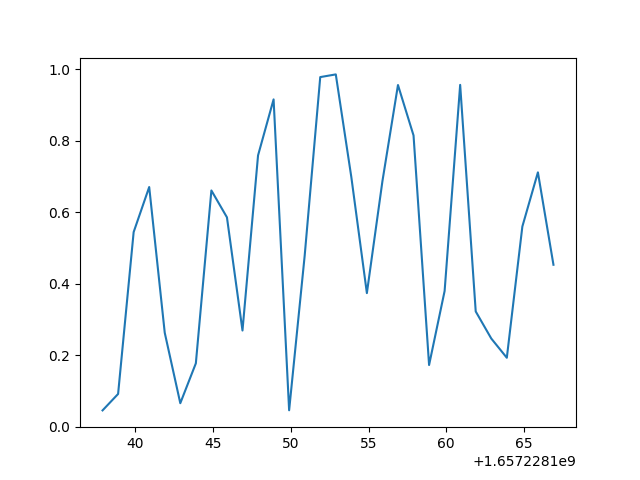

In [53]:
f = plt.subplots()
plt.plot(results.get_array('step0_uts'), results.get_array('step0_value_n'))